In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import os
import pandas as pd
import math

In [4]:
#Zuerst alle Namen der Bundesligateams webscrapen, damit man die jeweiligen URLs der Homeseiten der Vereine konstruieren kann
url = 'https://understat.com/league/Bundesliga'
variable_name = 'teamsData'

# Webseite laden
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
scripts = soup.find_all('script')

# Nach dem Script mit 'teamsData' suchen
for script in scripts:
    if variable_name in script.string:
        json_data_raw = script.string
        break

# JSON extrahieren und bereinigen
x = json_data_raw.find('(')
y = json_data_raw.find(')')
json_data_raw = json_data_raw[x+2:y-1]
json_clean = json_data_raw.encode().decode('unicode_escape')

# In Python-Dictionary umwandeln
data = json.loads(json_clean)

# In Datei speichern
filename = "alle_websiten.json"
with open(filename, "w", encoding='utf-8') as outfile:
    json.dump(data, outfile, indent=4, ensure_ascii=False)

# Datei einlesen und Teams extrahieren
with open(filename, 'r', encoding='utf-8') as infile:
    json_data = json.load(infile)

teams_list = list(json_data.values())
df = pd.DataFrame(teams_list)
team_namen = df['title'].tolist()
##Erzeugen aller HomeURLs der Bundesligateams
# Teamnamen anpassen
neu = []
for x in team_namen:
    if ' ' in x: 
        index = x.find(' ')
        neues_wort = x[:index] + '_' + x[index+1:]
        neu.append(neues_wort)
    else:
        neu.append(x)

# Team-URLs erzeugen
team_url_liste = [f"https://understat.com/team/{team_name}/2024" for team_name in neu]
print(team_url_liste)

['https://understat.com/team/Bayern_Munich/2024', 'https://understat.com/team/Bayer_Leverkusen/2024', 'https://understat.com/team/Hoffenheim/2024', 'https://understat.com/team/Augsburg/2024', 'https://understat.com/team/Werder_Bremen/2024', 'https://understat.com/team/Mainz_05/2024', 'https://understat.com/team/Borussia_Dortmund/2024', 'https://understat.com/team/Borussia_M.Gladbach/2024', 'https://understat.com/team/Wolfsburg/2024', 'https://understat.com/team/Eintracht_Frankfurt/2024', 'https://understat.com/team/VfB_Stuttgart/2024', 'https://understat.com/team/Freiburg/2024', 'https://understat.com/team/RasenBallsport_Leipzig/2024', 'https://understat.com/team/Union_Berlin/2024', 'https://understat.com/team/Bochum/2024', 'https://understat.com/team/FC_Heidenheim/2024', 'https://understat.com/team/Holstein_Kiel/2024', 'https://understat.com/team/St._Pauli/2024']


In [5]:
websiten_liste = []
for website in team_url_liste:
    url = website
    variable_name1 = 'datesData'
    response1 = requests.get(url)
    soup1 = BeautifulSoup(response1.content, "html.parser")
    scripts1 = soup1.find_all('script')
    # Nach dem Script mit 'datesData' suchen
    json_data_raw = None
    for script in scripts1:
        if variable_name1 in script.string:
            json_data_raw = script.string
            break
    if json_data_raw is None:
        print(f"⚠️ Keine 'datesData' auf {url} gefunden.")
        continue
    x = json_data_raw.find('(')
    y = json_data_raw.find(')')
    json_data_raw = json_data_raw[x + 2:y - 1]
    json_clean = json_data_raw.encode().decode('unicode_escape')
    # In Python-Dictionary umwandeln
    try:
        data = json.loads(json_clean)
    except json.JSONDecodeError:
        print(f"⚠️ Fehler beim Parsen der JSON-Daten auf {url}")
        continue
    # DataFrame aus Dictionary
    df = pd.DataFrame(data)
    # URLs extrahieren
    if df.empty:
        continue
    if df.columns[0] != 'id':
        df = df.rename(columns={df.columns[0]: 'id'})  # Falls die Spalte anders heißt
    match_ids = df['id'].tolist()
    # URLs generieren
    for match_id in match_ids:
        websiten_liste.append(f"https://understat.com/match/{match_id}")
# Duplikate entfernen
websiten_liste = list(set(websiten_liste))
# Optional: Speichern
with open("alle_spiel_urls.json", "w", encoding='utf-8') as f:
    json.dump(websiten_liste, f, indent=4, ensure_ascii=False)
print(f"Insgesamt {len(websiten_liste)} Match-URLs gesammelt.")

Insgesamt 306 Match-URLs gesammelt.


In [ ]:
# Aktueller Pfad
notebook_path = "."
if not os.path.exists(notebook_path):
    os.makedirs(notebook_path)
filename = os.path.join(notebook_path, "shots.json")
alle_shots = []
for url in websiten_liste:
    print(url)
    variable_name = 'shotsData'
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"⚠️ Fehler beim Abrufen von {url}")
            continue
    except requests.exceptions.RequestException as e:
        print(f"⚠️ Ausnahme bei {url}: {e}")
        continue
    soup = BeautifulSoup(response.content, "html.parser")
    scripts = soup.find_all('script')

    json_raw = None
    for script in scripts:
        if variable_name in script.text:
            start = script.text.find('JSON.parse("') + len('JSON.parse("')
            end = script.text.find('");', start)
            json_raw = script.text[start:end]
            break
    if not json_raw:
        print(f" Kein 'shotsData' auf Seite {url} gefunden.")
        continue
    try:
        # Entferne unnötige Klammerbereiche
        x = json_raw.find('(')
        y = json_raw.find(')')
        if x != -1 and y != -1:
            json_raw = json_raw[x+2:y-1]
        json_clean = json_raw.encode().decode('unicode_escape')
        data = json.loads(json_clean)
        alle_shots.append(data)
    except Exception as e:
        print(f"⚠️ Fehler beim Verarbeiten von {url}: {e}")
        continue
# Ergebnisse speichern
with open(filename, "w", encoding='utf-8') as outfile:
    json.dump(alle_shots, outfile, indent=4, ensure_ascii=False)

print(f"✅ {len(alle_shots)} Spiel-Datensätze erfolgreich gespeichert in {filename}.")
with open(filename, 'r', encoding='utf-8') as infile:
    json_data_shots = json.load(infile)

In [28]:
filename = os.path.join(".", "shots.json")
with open(filename, 'r', encoding='utf-8') as infile:
    json_data_shots = json.load(infile)
##Schüsse aus den Heim- und Auswärtscolumns rausziehen
alle_schuesse = []
# Alle Schüsse (heim und auswärts) aus jedem Spiel extrahieren
for spiel in json_data_shots:
    alle_schuesse.extend(spiel.get('h', []))  # Heimteam
    alle_schuesse.extend(spiel.get('a', []))  # Auswärtsteam
# In DataFrame umwandeln
shots = pd.DataFrame(alle_schuesse)
print(shots
     )

          id minute       result                   X                    Y  \
0     586014     17  MissedShots   0.860999984741211                0.495   
1     586016     24    SavedShot  0.8540000152587891   0.4109999847412109   
2     586019     29  BlockedShot  0.8469999694824218                 0.36   
3     586020     39  MissedShots  0.7780000305175782   0.3629999923706055   
4     586021     41  BlockedShot  0.9519999694824218    0.529000015258789   
...      ...    ...          ...                 ...                  ...   
7939  628408     80  MissedShots  0.8590000152587891                 0.37   
7940  628409     85  BlockedShot  0.8030000305175782   0.6869999694824219   
7941  628410     86  MissedShots                0.69  0.49900001525878906   
7942  628411     88    SavedShot                0.88   0.5509999847412109   
7943  628412     89  MissedShots  0.8169999694824219   0.4329999923706055   

                        xG           player h_a player_id situation season 

      x_meter    y_meter     winkel
0   90.404998  33.660000  28.141804
1   89.670002  27.947999  23.486873
2   88.934997  24.480000  19.325678
3   81.690003  24.683999  15.464604
4   99.959997  35.972001  66.691799
5  100.275000  32.436001  71.793284
6  100.379998  35.903999  71.106978
7   84.209997  24.547999  16.671532
8   89.565003  37.263999  25.630230
9   89.145002  36.040000  25.607928


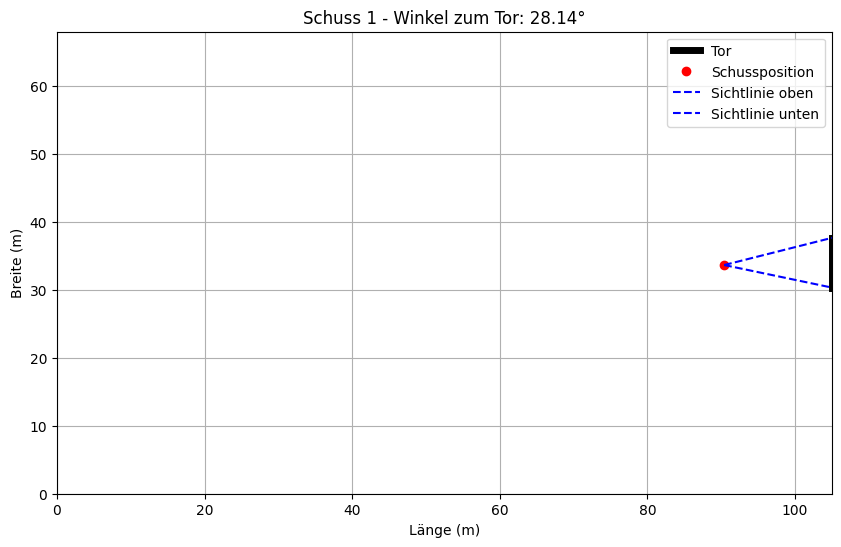

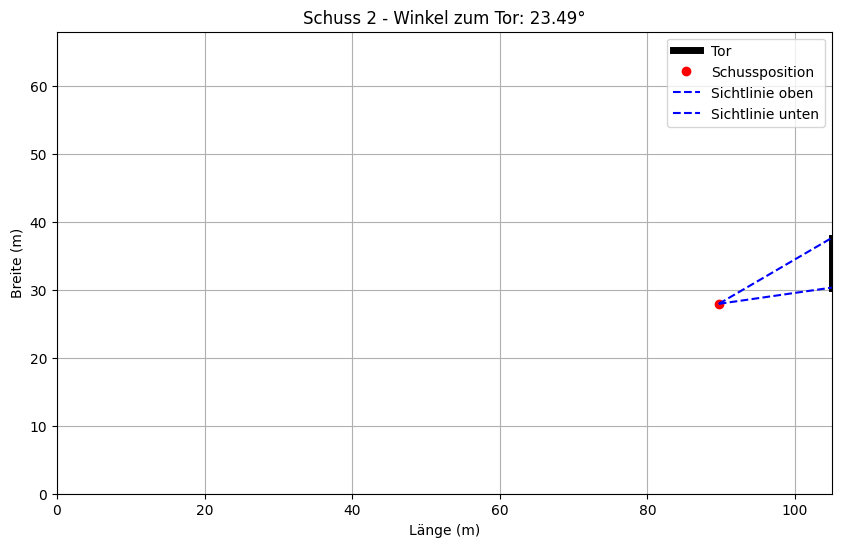

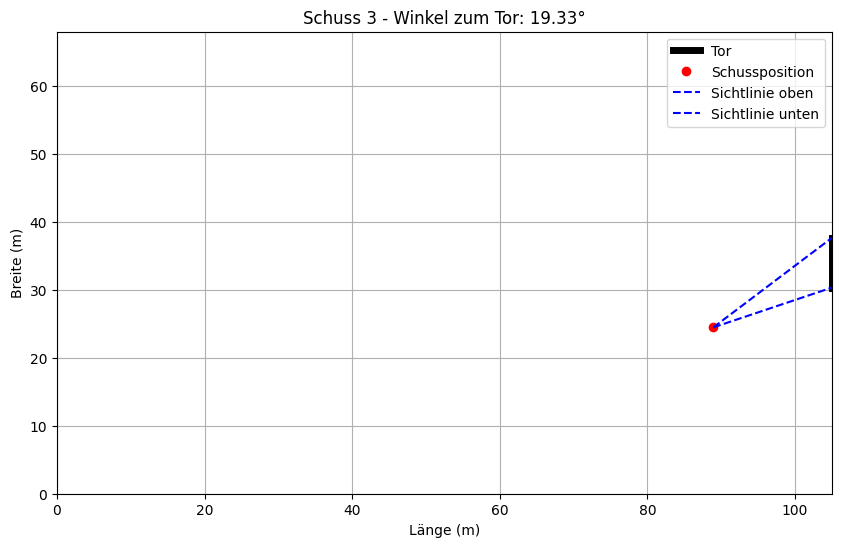

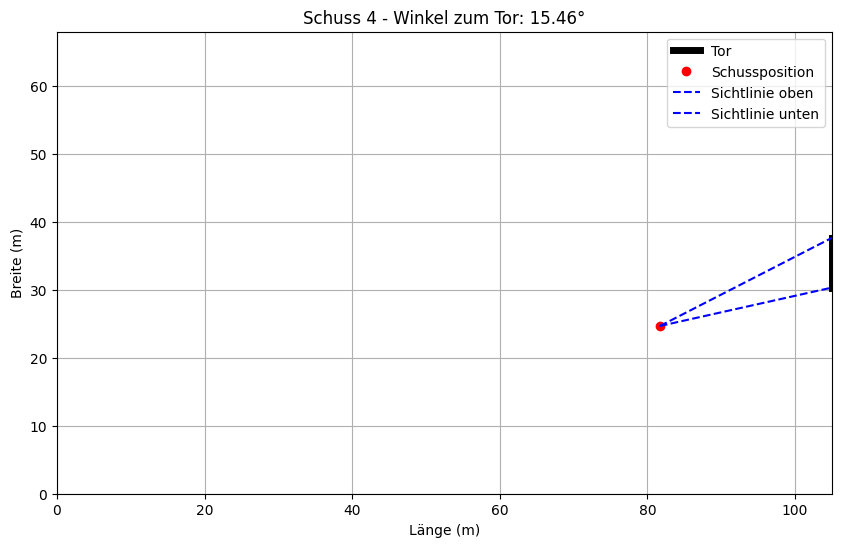

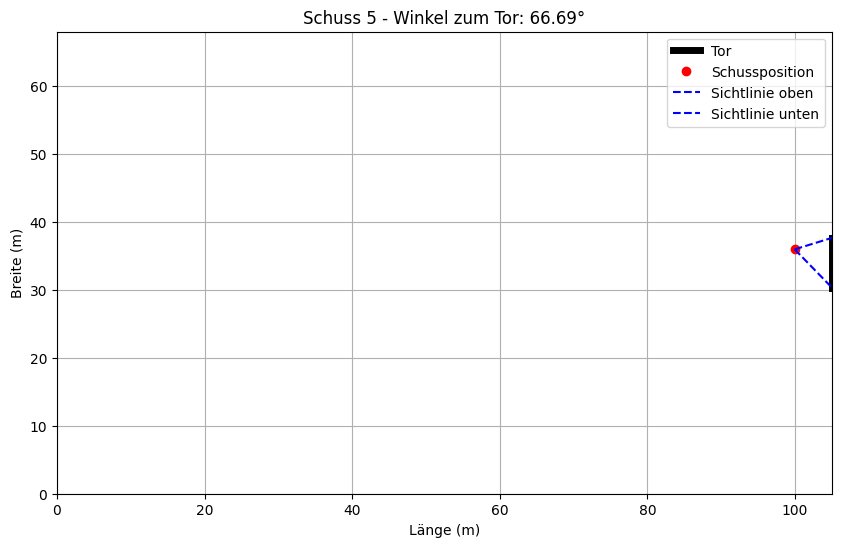

In [30]:
import math
import pandas as pd
import numpy as np

# Spielfeldmaße in Metern
laenge = 105
breite = 68
tor_breite = 7.32

# Torpfostenpositionen (rechtes Tor, aus Sicht der Heim-Mannschaft)
tor_x = 105
tor_y_mitte = breite / 2
tor_y_oben = tor_y_mitte + tor_breite / 2
tor_y_unten = tor_y_mitte - tor_breite / 2

# Leerer Ergebnis-DataFrame
shots_model = pd.DataFrame()

for i in range(len(shots)):
    # Rohdaten einlesen und umrechnen
    x_percentage = float(shots.loc[i, 'X'])
    y_percentage = float(shots.loc[i, 'Y'])
    x_meter = x_percentage * laenge
    y_meter = y_percentage * breite
    player = shots.loc[i, 'player']
    result = shots.loc[i, 'result']
    team = shots.loc[i, 'h_a']
    if(shots.loc[i, 'result']=='Goal'):
        isGoal = 1
    else: 
        isGoal = 0
    # Koordinaten anpassen je nach Spielseite
    if team == 'h':
        shot_x = x_meter
        shot_y = y_meter
        tor_x_angepasst = laenge  # rechtes Tor
    else:
        shot_x = laenge - x_meter
        shot_y = breite - y_meter
        tor_x_angepasst = 0  # linkes Tor
    
    # Distanzberechnung
    dist_x = abs(tor_x_angepasst - shot_x)
    dist_y = abs(shot_y - tor_y_mitte)
    dist = math.sqrt(dist_x**2 + dist_y**2)

    # Pfostenpositionen (für beide Seiten gleich)
    pfosten_oben = np.array([tor_x_angepasst, tor_y_oben])
    pfosten_unten = np.array([tor_x_angepasst, tor_y_unten])
    schuss_pos = np.array([shot_x, shot_y])

    # Vektoren vom Schuss zu den beiden Pfosten
    vec_oben = pfosten_oben - schuss_pos
    vec_unten = pfosten_unten - schuss_pos

    # Winkelberechnung mit arccos
    dot = np.dot(vec_oben, vec_unten)
    norms = np.linalg.norm(vec_oben) * np.linalg.norm(vec_unten)
    if norms == 0:
        winkel = 0.0
    else:
        cos_winkel = np.clip(dot / norms, -1.0, 1.0)
        winkel = math.degrees(math.acos(cos_winkel))

    # Zeile in Ergebnis-DataFrame einfügen
    row = {
        'player': player,
        'result': result,
        'team': team,
        'x_meter': x_meter,
        'y_meter': y_meter,
        'dist_x': dist_x,
        'dist_y': dist_y,
        'dist': dist,
        'winkel': winkel,
        'isGoal': isGoal
    }

    shots_model = pd.concat([shots_model, pd.DataFrame([row])], ignore_index=True)

# Ergebnis anzeigen
print(shots_model[['x_meter', 'y_meter', 'winkel']].head(10))

import matplotlib.pyplot as plt
#Überprüfen, ob die Berechnungen realistisch sind
# Zeichne die ersten 5 Schüsse
for idx in range(5):
    row = shots_model.iloc[idx]

    # Position je nach Team anpassen
    if row['team'] == 'h':
        shot_x = row['x_meter']
        shot_y = row['y_meter']
    else:
        shot_x = laenge - row['x_meter']
        shot_y = breite - row['y_meter']

    plt.figure(figsize=(10,6))
    
    # Torpfosten zeichnen
    plt.plot([tor_x, tor_x], [tor_y_unten, tor_y_oben], 'k-', linewidth=5, label='Tor')
    
    # Schussposition
    plt.plot(shot_x, shot_y, 'ro', label='Schussposition')
    
    # Sichtlinien zu Torpfosten
    plt.plot([shot_x, tor_x], [shot_y, tor_y_oben], 'b--', label='Sichtlinie oben')
    plt.plot([shot_x, tor_x], [shot_y, tor_y_unten], 'b--', label='Sichtlinie unten')
    
    plt.title(f"Schuss {idx+1} - Winkel zum Tor: {row['winkel']:.2f}°")
    plt.xlabel('Länge (m)')
    plt.ylabel('Breite (m)')
    plt.xlim(0, laenge)
    plt.ylim(0, breite)
    plt.grid(True)
    plt.legend()
    plt.show()


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Beispiel: Features und Zielvariable
X = shots_model[['dist', 'winkel']]
y = shots_model['isGoal']

# Daten in Trainings- und Testset splitten (z.B. 80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell initialisieren
logreg = LogisticRegression(max_iter=1000)

# Modell trainieren
logreg.fit(X_train, y_train)

# Vorhersage auf Testdaten
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1388
           1       0.64      0.04      0.08       201

    accuracy                           0.88      1589
   macro avg       0.76      0.52      0.51      1589
weighted avg       0.85      0.88      0.83      1589

ROC-AUC Score: 0.6949295310192554
Confusion Matrix:
 [[1383    5]
 [ 192    9]]
